# Encoder Training

## Setup

In [1]:
from google.colab import userdata, drive
import os

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split

In [3]:
if torch.cuda.is_available():
  device = "cuda"
elif torch.backends.mps.is_available():
  device = "mps"
else:
  device = "cpu"

device

'cpu'

In [4]:
base_path = "drive/MyDrive/Education/STAT 5330 Project/"
data_path = os.path.join(base_path, "data")
fp = "phase_1/encoder_training_data.csv"

training_data_fp = os.path.join(data_path, fp)
X = pd.read_csv(training_data_fp)

X.head()

,0,1,2,3,4,5,6,7,8,9
0,0.844154,-0.433272,-1.179060,-0.098168,2.060223,1.430463,0.130121,-0.224651,1.220989,-0.371878
1,0.916910,-0.183143,0.112213,-0.544410,-0.342717,-0.150677,1.397204,-0.473737,-0.157092,3.797265
2,-0.054467,0.095909,-0.753939,1.807115,-1.206196,-0.594574,-0.224142,0.042384,1.322532,0.033469
3,-1.822013,-0.764473,0.297403,0.102300,0.624735,0.356276,-0.332814,0.453374,-0.272904,0.204088
4,-1.536298,-0.021844,0.153684,0.084611,-0.872356,-1.601389,-0.048672,-2.542586,0.014689,-0.075960


In [5]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1176724.0,-1.409342e-17,1.0,-3.674302,-0.713690,0.245476,0.808928,2.098700
1,1176724.0,-9.963216e-18,1.0,-3.738349,-0.640323,-0.009902,0.595928,6.076167
2,1176724.0,-1.072404e-17,1.0,-2.066078,-0.629130,-0.197578,0.330371,7.245531
3,1176724.0,-5.691110e-18,1.0,-5.302136,-0.704738,-0.106474,0.612973,6.918854
4,1176724.0,2.735356e-17,1.0,-3.573802,-0.734938,-0.104160,0.683124,6.498377
5,1176724.0,-1.927429e-17,1.0,-4.637495,-0.721003,-0.038648,0.610077,5.263854
6,1176724.0,2.226326e-17,1.0,-4.618342,-0.676301,-0.036038,0.652265,4.790886
7,1176724.0,-2.388756e-17,1.0,-10.330278,-0.605033,-0.026235,0.651792,6.149674
8,1176724.0,-7.620351e-18,1.0,-10.500145,-0.623887,0.008707,0.627298,8.944644
9,1176724.0,-6.738757e-18,1.0,-3.429043,-0.378465,-0.182342,0.059180,4.911363


In [6]:
from typing import Union, Sequence

class AutoEncoder(nn.Module):
  def __init__(self,
               in_dim: int,
               bn_dim: int,
               hidden_dims: Union[int, Sequence[int]],
               activation: nn.Module = nn.ReLU(),
               output_activation: None | nn.Module = None,
               dropout_rate: float = 0.0,
               use_layer_norm: bool = False
               ):

    super().__init__()

    if isinstance(hidden_dims, int):
      hidden_dims = [hidden_dims]
    else:
      hidden_dims = list(hidden_dims)

    # ---------- ENCODER ----------
    encoder_layers = []
    prev_dim = in_dim
    for h in hidden_dims:
      layer = nn.Linear(prev_dim, h)
      encoder_layers.append(layer)
      # create a fresh instance of the same activation class
      encoder_layers.append(type(activation)())
      if use_layer_norm:
          encoder_layers.append(nn.LayerNorm(h))
      if dropout_rate > 0:
          encoder_layers.append(nn.Dropout(dropout_rate))

      prev_dim = h

    # bottleneck (no activation after it)
    bn_layer = nn.Linear(prev_dim, bn_dim)
    encoder_layers.append(bn_layer)

    self.encoder = nn.Sequential(*encoder_layers)

    # ---------- DECODER ----------
    decoder_layers = []
    prev_dim = bn_dim
    for h in reversed(hidden_dims):
      layer = nn.Linear(prev_dim, h)
      decoder_layers.append(layer)
      # create a fresh instance of the same activation class
      decoder_layers.append(type(activation)())

      prev_dim = h

    output_layer = nn.Linear(prev_dim, in_dim)
    decoder_layers.append(output_layer)
    # checks whether initiated with output activation
    if output_activation is not None:
      decoder_layers.append(output_activation)

    self.decoder = nn.Sequential(*decoder_layers)

  # ---------- API METHODS ----------

  def forward(self, X):
    z = self.encoder(X)
    out = self.decoder(z)
    return out

  def encode(self, X):
    """Return bottleneck representation z."""
    return self.encoder(X)

  def decode(self, X):
    """Return decoded representation x hat."""
    return self.decoder(X)

class TiedAutoEncoder(nn.Module):
    def __init__(
        self,
        in_dim: int,
        bn_dim: int,
        hidden_dims: Union[int, Sequence[int]],
        activation: nn.Module = nn.ReLU(),
        output_activation: nn.Module | None = None,
        encoder_bias: bool = True,
        decoder_bias: bool = False,
        dropout_rate: float = 0.0,
        use_layer_norm: bool = False
    ):

        super().__init__()

        self.activation = activation
        self.output_activation = output_activation
        self.use_decoder_bias = decoder_bias

        # ---- Handle hidden dims ----
        if isinstance(hidden_dims, int):
            hidden_dims = [hidden_dims]
        else:
            hidden_dims = list(hidden_dims)

        # ---------- ENCODER ----------
        encoder_layers: list[nn.Module] = []
        prev_dim = in_dim

        for h in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h, bias=encoder_bias))
            encoder_layers.append(type(activation)())  # new instance
            if use_layer_norm:
                encoder_layers.append(nn.LayerNorm(h))
            if dropout_rate > 0:
                encoder_layers.append(nn.Dropout(dropout_rate))
            prev_dim = h

        # bottleneck (no activation after it)
        bn_layer = nn.Linear(prev_dim, bn_dim, bias=encoder_bias)
        encoder_layers.append(bn_layer)

        self.encoder = nn.Sequential(*encoder_layers)

        # indices of the Linear layers in the encoder
        self.linear_idx = [
            i for i, m in enumerate(self.encoder)
            if isinstance(m, nn.Linear)
        ]

        # ---------- DECODER BIASES ----------
        if self.use_decoder_bias:
            # One bias per decoder Linear layer (in reverse order)
            self.decoder_bias = nn.ParameterList([
                nn.Parameter(torch.zeros(self.encoder[idx].in_features))
                for idx in reversed(self.linear_idx)
            ])
        else:
            self.decoder_bias = None

    # ---------- API METHODS ----------

    def encode(self, X: torch.Tensor) -> torch.Tensor:
        """Return bottleneck representation z."""
        return self.encoder(X)

    def decode(self, Z: torch.Tensor) -> torch.Tensor:
        """Decode from bottleneck using tied weights (and optional decoder bias)."""
        X = Z
        num_linear = len(self.linear_idx)

        for step, idx in enumerate(reversed(self.linear_idx)):
            lin = self.encoder[idx]        # nn.Linear
            W = lin.weight                 # (out_dim, in_dim)

            if self.use_decoder_bias:
                b = self.decoder_bias[step]
                X = F.linear(X, W.t(), b)
            else:
                X = F.linear(X, W.t())

            is_last_step = (step == num_linear - 1)
            if not is_last_step:
                X = self.activation(X)

        if self.output_activation is not None:
            X = self.output_activation(X)

        return X

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        Z = self.encode(X)
        out = self.decode(Z)
        return out

In [7]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0.01):
    self.patience = patience
    self.delta = delta
    self.best_score = None
    self.early_stop = False
    self.counter = 0
    self.best_model_state = None

  def __call__(self, val_loss, model):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.best_model_state = model.state_dict()

    elif score < self.best_score + self.delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      self.best_score = score
      self.best_model_state = model.state_dict()
      self.counter = 0

  def load_best_model(self, model):
    model.load_state_dict(self.best_model_state)

def bgd(
    model,
    train_loader,
    val_loader,
    optim,
    criterion,
    early_stopper,
    epochs,
    max_lr=1e-3,
    pct_start=0.3,
):
    train_losses, val_losses, lrs = [], [], []

    # ----- CREATE SCHEDULER -----
    scheduler = OneCycleLR(
        optim,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=pct_start,
    )

    # ----- TRAINING LOOP -----
    pbar = tqdm(range(epochs), desc=f"Epoch 0/{epochs}", unit="epoch", ncols=100)

    for epoch in pbar:
        model.train()
        batch_train_losses = []

        for (Xb,) in train_loader:
            Xb = Xb.to(device)

            pred = model(Xb)
            loss = criterion(pred, Xb)
            loss.backward()

            optim.step()
            optim.zero_grad()

            # update LR *after* optimizer step
            scheduler.step()

            batch_train_losses.append(loss.item())

        epoch_train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(epoch_train_loss)

        # ----- VALIDATION -----
        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for (Xb,) in val_loader:
                Xb = Xb.to(device)
                pred = model(Xb)
                loss = criterion(pred, Xb)
                batch_val_losses.append(loss.item())

        epoch_val_loss = sum(batch_val_losses) / len(batch_val_losses)
        val_losses.append(epoch_val_loss)

        # ----- UPDATE TQDM -----
        current_lr = scheduler.get_last_lr()[0]
        lrs.append(current_lr)

        pbar.set_description(f"Epoch {epoch+1}/{epochs}")
        pbar.set_postfix(
            train_loss=f"{epoch_train_loss:.4f}",
            val_loss=f"{epoch_val_loss:.4f}",
            # lr=f"{current_lr:.2e}",
        )
        pbar.refresh()
        print()

        # ----- EARLY STOPPING -----
        early_stopper(epoch_val_loss, model)
        if early_stopper.early_stop:
            tqdm.write(
                f"Early stopping at epoch {epoch+1}/{epochs}: "
                f"train_loss={epoch_train_loss:.4f}, "
                f"val_loss={epoch_val_loss:.4f}"
            )
            break

    return train_losses, val_losses, lrs


def plot_losses(train_losses, val_losses):
    fig, ax = subplots(1,1, figsize=(10,6))

    ax.plot(train_losses, label="Training Loss")
    ax.plot(val_losses, label="Validation Loss")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.tight_layout()

    return fig


def plot_lr(lrs):
    fig, ax = subplots(1,1, figsize=(10,6))
    ax.plot(lrs, label="Learning Rate")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Learning Rate")
    ax.legend()
    plt.tight_layout()

    return fig


def save_model(model, hyperparams, model_name, path=""):
  model_data = {
      "model_state_dict": model.state_dict(),
      "model_hyperparameters": hyperparams
  }
  torch.save(model_data, f"{path}{model_name}.pt")

def load_model(model_class:nn.Module, model_name, device):
  loaded_data = torch.load(model_name, weights_only=True)
  new_model = model_class(**loaded_data["model_hyperparameters"])
  new_model.load_state_dict(loaded_data["model_state_dict"])
  new_model.to(device)
  new_model.eval()
  return new_model


In [8]:
from dataclasses import dataclass
from typing import Sequence, Callable
import re


@dataclass
class AEConfig:
    in_dim: int
    bn_dim: int
    hidden_dims: Sequence[int]
    lr: float = 1e-3
    epochs: int = 100
    patience: int = 10
    min_delta: float = 0.01


def make_autoencoder(cfg: AEConfig) -> nn.Module:
    return AutoEncoder(
        in_dim=cfg.in_dim,
        bn_dim=cfg.bn_dim,
        hidden_dims=cfg.hidden_dims,
    )


def make_tied_autoencoder(cfg: AEConfig) -> nn.Module:
    return TiedAutoEncoder(
        in_dim=cfg.in_dim,
        bn_dim=cfg.bn_dim,
        hidden_dims=cfg.hidden_dims,
        encoder_bias=True,
        decoder_bias=True,
    )


def make_model_name(model_type: str, hidden_dims, bn_dim: int) -> str:
    hdims = "-".join(str(h) for h in hidden_dims)
    name = f"{model_type}-{hdims}-{bn_dim}"
    name = re.sub(r"[^A-Za-z0-9\-]", "", name)
    name = re.sub(r"-+", "-", name).strip("-")

    return name


def run_ae_experiment(
    cfg: AEConfig,
    model_fn: Callable[[AEConfig], nn.Module],
    train_loader,
    val_loader,
    device: torch.device,
):

    # ---- build model ----
    model = model_fn(cfg)
    model.to(device)


    if model_fn.__name__ == "make_autoencoder":
        model_type = "ae"
        optim = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    elif model_fn.__name__ == "make_tied_autoencoder":
        model_type = "tae"
        optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

    else:
        raise ValueError("model type not identified")

    model_name = make_model_name(model_type, cfg.hidden_dims, cfg.bn_dim)

    print(f"Generated model_name: {model_name}")

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params}\n")


    # ---- crit / early stopping ----

    criterion = nn.MSELoss()
    early_stopper = EarlyStopping(cfg.patience, cfg.min_delta)


    # ---- train ----
    train_losses, val_losses, lr = bgd(
        model,
        train_loader,
        val_loader,
        optim,
        criterion,
        early_stopper,
        cfg.epochs,
    )


    # ---- plots ----
    fig_loss = plot_losses(train_losses, val_losses)
    lr_loss = plot_lr(lr)


    # ---- save ----
    save_model(
        model,
        {
            "in_dim": cfg.in_dim,
            "bn_dim": cfg.bn_dim,
            "hidden_dims": list(cfg.hidden_dims),
        },
        model_name,
    )


    return {
        "model": model_name,
        "hidden_dims": cfg.hidden_dims,
        "bottleneck_dim": cfg.bn_dim,
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "params": total_params
    }



In [9]:
X_train, X_test = train_test_split(X.to_numpy(), train_size=0.8, shuffle=True, random_state=42)
X_train, X_val = train_test_split(X_train, train_size=0.8, shuffle=True, random_state=42)

X_train_transformed = torch.FloatTensor(X_train)
X_val_transformed = torch.FloatTensor(X_val)
X_test_transformed = torch.FloatTensor(X_test)

X_train_transformed = X_train_transformed.to(device)
X_val_transformed = X_val_transformed.to(device)
X_test_transformed = X_test_transformed.to(device)

train_dataset = TensorDataset(X_train_transformed)
val_dataset = TensorDataset(X_val_transformed)
test_dataset = TensorDataset(X_test_transformed)

train_dataloader = DataLoader(train_dataset, batch_size=512)
val_dataloader = DataLoader(val_dataset, batch_size=512)

next(iter(train_dataloader))[0].shape

torch.Size([512, 10])

## Training

In [10]:
results = []

Generated model_name: ae-64-32-16-3
Model parameters: 6733



Epoch 1/100:   1%|           | 1/100 [00:11<19:15, 11.67s/epoch, train_loss=0.9125, val_loss=0.7749]

Epoch 2/100:   2%|▏          | 2/100 [00:23<18:45, 11.48s/epoch, train_loss=0.6811, val_loss=0.5754]

Epoch 3/100:   3%|▎          | 3/100 [00:33<17:30, 10.83s/epoch, train_loss=0.5093, val_loss=0.4751]

Epoch 4/100:   4%|▍          | 4/100 [00:43<17:11, 10.74s/epoch, train_loss=0.4532, val_loss=0.4327]

Epoch 5/100:   5%|▌          | 5/100 [00:54<17:06, 10.80s/epoch, train_loss=0.4112, val_loss=0.3909]

Epoch 6/100:   6%|▋          | 6/100 [01:05<16:57, 10.83s/epoch, train_loss=0.3727, val_loss=0.3554]

Epoch 7/100:   7%|▊          | 7/100 [01:14<16:04, 10.37s/epoch, train_loss=0.3395, val_loss=0.3258]

Epoch 8/100:   8%|▉          | 8/100 [01:25<16:00, 10.44s/epoch, train_loss=0.3133, val_loss=0.3024]

Epoch 9/100:   9%|▉          | 9/100 [01:36<15:56, 10.51s/epoch, train_loss=0.2900, val_loss=0.2798]

Epoch 10/100:  10%|▉        | 10/100 [01:46<15:52, 10.58s/epoch, train_loss=0.2703, val_loss=0.2635]

Epoch 11/100:  11%|▉        | 11/100 [01:56<15:09, 10.22s/epoch, train_loss=0.2564, val_loss=0.2510]

Epoch 12/100:  12%|█        | 12/100 [02:07<15:16, 10.41s/epoch, train_loss=0.2450, val_loss=0.2406]

Epoch 13/100:  13%|█▏       | 13/100 [02:17<15:17, 10.54s/epoch, train_loss=0.2357, val_loss=0.2321]

Epoch 14/100:  14%|█▎       | 14/100 [02:28<15:08, 10.56s/epoch, train_loss=0.2274, val_loss=0.2252]

Epoch 15/100:  15%|█▎       | 15/100 [02:38<14:41, 10.37s/epoch, train_loss=0.2199, val_loss=0.2183]

Epoch 16/100:  16%|█▍       | 16/100 [02:48<14:32, 10.39s/epoch, train_loss=0.2131, val_loss=0.2113]

Epoch 17/100:  17%|█▌       | 17/100 [02:59<14:30, 10.49s/epoch, train_loss=0.2073, val_loss=0.2051]

Epoch 18/100:  18%|█▌       | 18/100 [03:10<14:27, 10.58s/epoch, train_loss=0.2018, val_loss=0.1995]

Epoch 19/100:  19%|█▋       | 19/100 [03:20<14:15, 10.56s/epoch, train_loss=0.1967, val_loss=0.1945]

Epoch 20/100:  20%|█▊       | 20/100 [03:30<13:50, 10.38s/epoch, train_loss=0.1921, val_loss=0.1911]

Epoch 21/100:  21%|█▉       | 21/100 [03:41<13:51, 10.53s/epoch, train_loss=0.1877, val_loss=0.1862]

Epoch 22/100:  22%|█▉       | 22/100 [03:52<13:47, 10.60s/epoch, train_loss=0.1838, val_loss=0.1815]

Epoch 23/100:  23%|██       | 23/100 [04:03<13:42, 10.68s/epoch, train_loss=0.1803, val_loss=0.1792]

Epoch 24/100:  24%|██▏      | 24/100 [04:13<13:09, 10.39s/epoch, train_loss=0.1770, val_loss=0.1760]

Epoch 25/100:  25%|██▎      | 25/100 [04:23<12:59, 10.39s/epoch, train_loss=0.1734, val_loss=0.1713]

Epoch 26/100:  26%|██▎      | 26/100 [04:34<13:00, 10.54s/epoch, train_loss=0.1702, val_loss=0.1688]

Epoch 27/100:  27%|██▍      | 27/100 [04:45<12:56, 10.63s/epoch, train_loss=0.1671, val_loss=0.1662]

Epoch 28/100:  28%|██▌      | 28/100 [04:55<12:35, 10.49s/epoch, train_loss=0.1644, val_loss=0.1639]

Epoch 29/100:  29%|██▌      | 29/100 [05:05<12:20, 10.43s/epoch, train_loss=0.1620, val_loss=0.1620]

Epoch 30/100:  30%|██▋      | 30/100 [05:16<12:18, 10.55s/epoch, train_loss=0.1603, val_loss=0.1589]

Epoch 31/100:  31%|██▊      | 31/100 [05:27<12:11, 10.60s/epoch, train_loss=0.1579, val_loss=0.1568]

Epoch 32/100:  32%|██▉      | 32/100 [05:38<12:04, 10.66s/epoch, train_loss=0.1557, val_loss=0.1542]

Epoch 33/100:  33%|██▉      | 33/100 [05:47<11:34, 10.37s/epoch, train_loss=0.1546, val_loss=0.1559]

Epoch 34/100:  34%|███      | 34/100 [05:58<11:31, 10.47s/epoch, train_loss=0.1531, val_loss=0.1526]

Epoch 35/100:  35%|███▏     | 35/100 [06:09<11:27, 10.57s/epoch, train_loss=0.1526, val_loss=0.1531]

Epoch 36/100:  36%|███▏     | 36/100 [06:19<11:16, 10.56s/epoch, train_loss=0.1520, val_loss=0.1517]

Epoch 37/100:  37%|███▎     | 37/100 [06:29<10:50, 10.33s/epoch, train_loss=0.1512, val_loss=0.1524]

Epoch 38/100:  38%|███▍     | 38/100 [06:40<10:44, 10.40s/epoch, train_loss=0.1501, val_loss=0.1506]

Epoch 39/100:  39%|███▌     | 39/100 [06:50<10:40, 10.50s/epoch, train_loss=0.1491, val_loss=0.1493]

Epoch 40/100:  40%|███▌     | 40/100 [07:01<10:33, 10.57s/epoch, train_loss=0.1482, val_loss=0.1506]

Epoch 41/100:  41%|███▋     | 41/100 [07:12<10:20, 10.52s/epoch, train_loss=0.1473, val_loss=0.1485]

Epoch 42/100:  42%|███▊     | 42/100 [07:22<10:01, 10.37s/epoch, train_loss=0.1458, val_loss=0.1461]

Epoch 43/100:  43%|███▊     | 43/100 [07:32<09:55, 10.45s/epoch, train_loss=0.1455, val_loss=0.1462]

Epoch 44/100:  43%|███▊     | 43/100 [07:43<10:14, 10.78s/epoch, train_loss=0.1443, val_loss=0.1434]



Early stopping at epoch 44/100: train_loss=0.1443, val_loss=0.1434


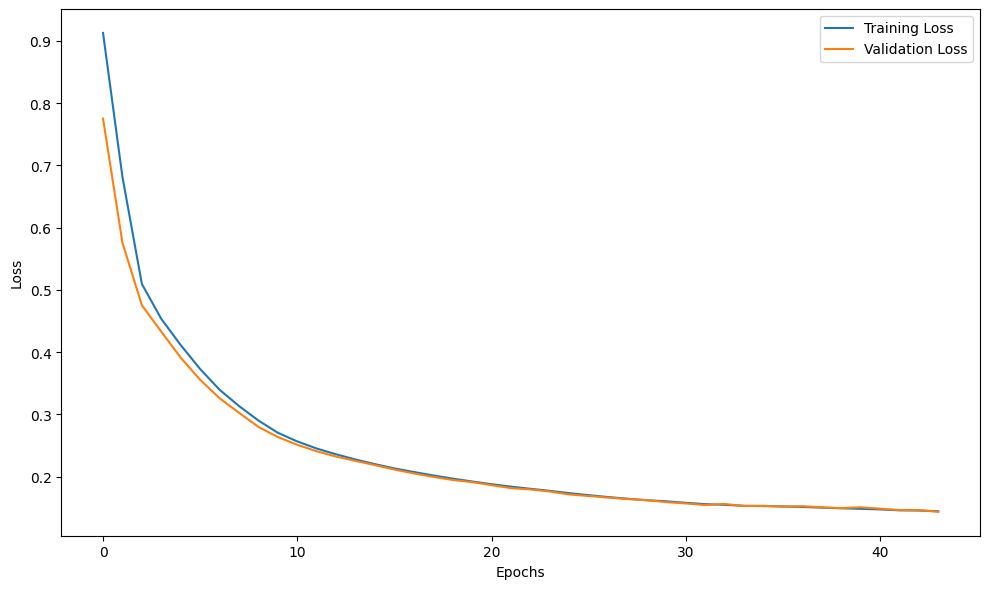

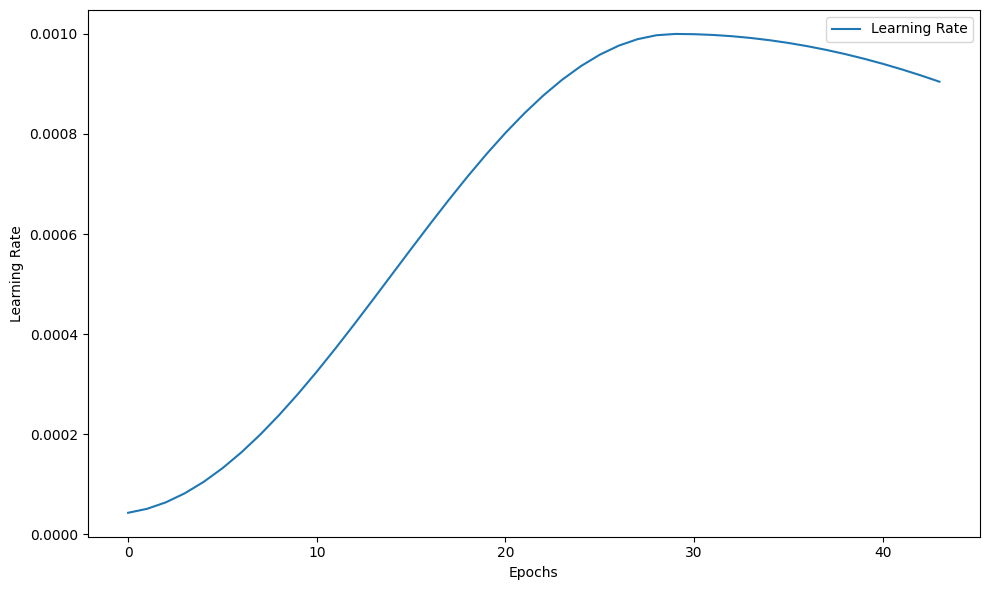

In [11]:
n_dim = X_train_transformed.shape[1]

cfg = AEConfig(
    in_dim=n_dim,
    bn_dim=3,
    hidden_dims=[64, 32, 16],
    )

results.append(
    run_ae_experiment(
      cfg,
      model_fn=make_autoencoder,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      device=device)
)

Generated model_name: tae-64-32-16-3
Model parameters: 3485



Epoch 1/100:   1%|           | 1/100 [00:10<17:39, 10.70s/epoch, train_loss=0.9292, val_loss=0.8482]

Epoch 2/100:   2%|▏          | 2/100 [00:20<16:13,  9.93s/epoch, train_loss=0.7134, val_loss=0.6079]

Epoch 3/100:   3%|▎          | 3/100 [00:30<16:41, 10.33s/epoch, train_loss=0.5049, val_loss=0.4422]

Epoch 4/100:   4%|▍          | 4/100 [00:41<16:45, 10.47s/epoch, train_loss=0.4218, val_loss=0.4035]

Epoch 5/100:   5%|▌          | 5/100 [00:52<16:44, 10.58s/epoch, train_loss=0.3863, val_loss=0.3682]

Epoch 6/100:   6%|▋          | 6/100 [01:02<16:16, 10.39s/epoch, train_loss=0.3515, val_loss=0.3338]

Epoch 7/100:   7%|▊          | 7/100 [01:12<16:03, 10.36s/epoch, train_loss=0.3162, val_loss=0.2995]

Epoch 8/100:   8%|▉          | 8/100 [01:23<16:04, 10.49s/epoch, train_loss=0.2868, val_loss=0.2747]

Epoch 9/100:   9%|▉          | 9/100 [01:34<16:02, 10.58s/epoch, train_loss=0.2665, val_loss=0.2586]

Epoch 10/100:  10%|▉        | 10/100 [01:44<15:46, 10.52s/epoch, train_loss=0.2522, val_loss=0.2463]

Epoch 11/100:  11%|▉        | 11/100 [01:54<15:16, 10.29s/epoch, train_loss=0.2403, val_loss=0.2353]

Epoch 12/100:  12%|█        | 12/100 [02:05<15:25, 10.52s/epoch, train_loss=0.2289, val_loss=0.2239]

Epoch 13/100:  13%|█▏       | 13/100 [02:16<15:21, 10.60s/epoch, train_loss=0.2179, val_loss=0.2139]

Epoch 14/100:  14%|█▎       | 14/100 [02:27<15:17, 10.67s/epoch, train_loss=0.2082, val_loss=0.2039]

Epoch 15/100:  15%|█▎       | 15/100 [02:36<14:35, 10.30s/epoch, train_loss=0.1999, val_loss=0.1968]

Epoch 16/100:  16%|█▍       | 16/100 [02:47<14:36, 10.43s/epoch, train_loss=0.1932, val_loss=0.1908]

Epoch 17/100:  17%|█▌       | 17/100 [02:57<14:33, 10.52s/epoch, train_loss=0.1880, val_loss=0.1858]

Epoch 18/100:  18%|█▌       | 18/100 [03:08<14:27, 10.58s/epoch, train_loss=0.1836, val_loss=0.1817]

Epoch 19/100:  19%|█▋       | 19/100 [03:18<14:01, 10.39s/epoch, train_loss=0.1803, val_loss=0.1797]

Epoch 20/100:  20%|█▊       | 20/100 [03:28<13:44, 10.31s/epoch, train_loss=0.1768, val_loss=0.1744]

Epoch 21/100:  21%|█▉       | 21/100 [03:39<13:46, 10.46s/epoch, train_loss=0.1730, val_loss=0.1707]

Epoch 22/100:  22%|█▉       | 22/100 [03:49<13:35, 10.46s/epoch, train_loss=0.1697, val_loss=0.1679]

Epoch 23/100:  23%|██       | 23/100 [04:00<13:29, 10.51s/epoch, train_loss=0.1669, val_loss=0.1657]

Epoch 24/100:  24%|██▏      | 24/100 [04:10<13:01, 10.29s/epoch, train_loss=0.1641, val_loss=0.1625]

Epoch 25/100:  25%|██▎      | 25/100 [04:21<13:00, 10.40s/epoch, train_loss=0.1616, val_loss=0.1602]

Epoch 26/100:  26%|██▎      | 26/100 [04:31<12:55, 10.48s/epoch, train_loss=0.1594, val_loss=0.1587]

Epoch 27/100:  27%|██▍      | 27/100 [04:42<12:48, 10.53s/epoch, train_loss=0.1565, val_loss=0.1561]

Epoch 28/100:  28%|██▌      | 28/100 [04:51<12:17, 10.24s/epoch, train_loss=0.1542, val_loss=0.1533]

Epoch 29/100:  29%|██▌      | 29/100 [05:02<12:19, 10.42s/epoch, train_loss=0.1510, val_loss=0.1516]

Epoch 30/100:  30%|██▋      | 30/100 [05:13<12:15, 10.50s/epoch, train_loss=0.1491, val_loss=0.1456]

Epoch 31/100:  31%|██▊      | 31/100 [05:24<12:05, 10.52s/epoch, train_loss=0.1459, val_loss=0.1457]

Epoch 32/100:  32%|██▉      | 32/100 [05:33<11:42, 10.33s/epoch, train_loss=0.1448, val_loss=0.1434]

Epoch 33/100:  33%|██▉      | 33/100 [05:44<11:29, 10.30s/epoch, train_loss=0.1431, val_loss=0.1427]

Epoch 34/100:  34%|███      | 34/100 [05:55<11:31, 10.48s/epoch, train_loss=0.1426, val_loss=0.1434]

Epoch 35/100:  35%|███▏     | 35/100 [06:05<11:24, 10.54s/epoch, train_loss=0.1416, val_loss=0.1411]

Epoch 36/100:  36%|███▏     | 36/100 [06:15<11:02, 10.36s/epoch, train_loss=0.1416, val_loss=0.1395]

Epoch 37/100:  37%|███▎     | 37/100 [06:25<10:49, 10.31s/epoch, train_loss=0.1409, val_loss=0.1396]

Epoch 38/100:  38%|███▍     | 38/100 [06:36<10:44, 10.40s/epoch, train_loss=0.1390, val_loss=0.1402]

Epoch 39/100:  39%|███▌     | 39/100 [06:46<10:36, 10.44s/epoch, train_loss=0.1377, val_loss=0.1384]

Epoch 40/100:  39%|███▌     | 39/100 [06:57<10:52, 10.70s/epoch, train_loss=0.1372, val_loss=0.1371]



Early stopping at epoch 40/100: train_loss=0.1372, val_loss=0.1371


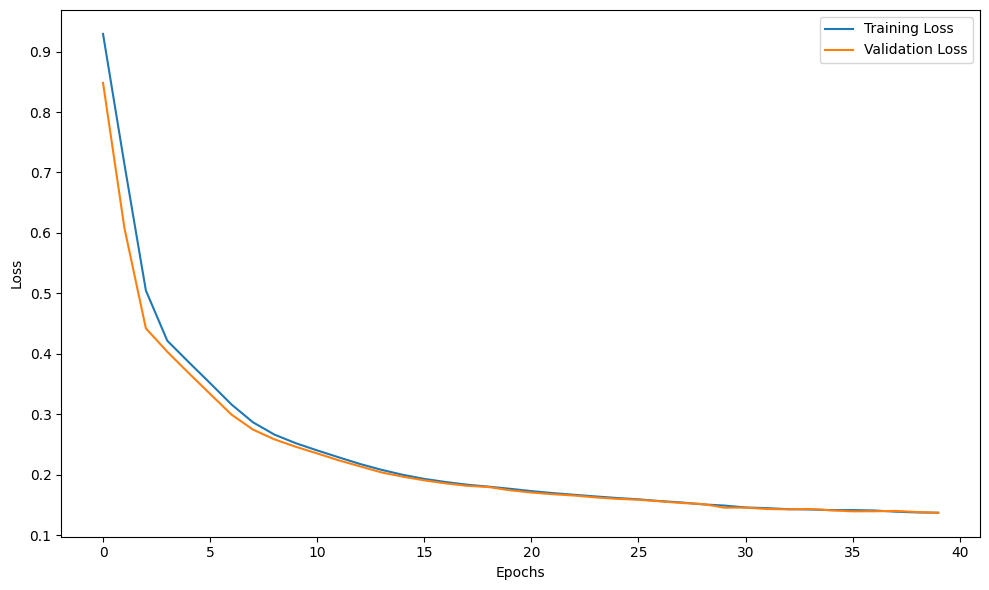

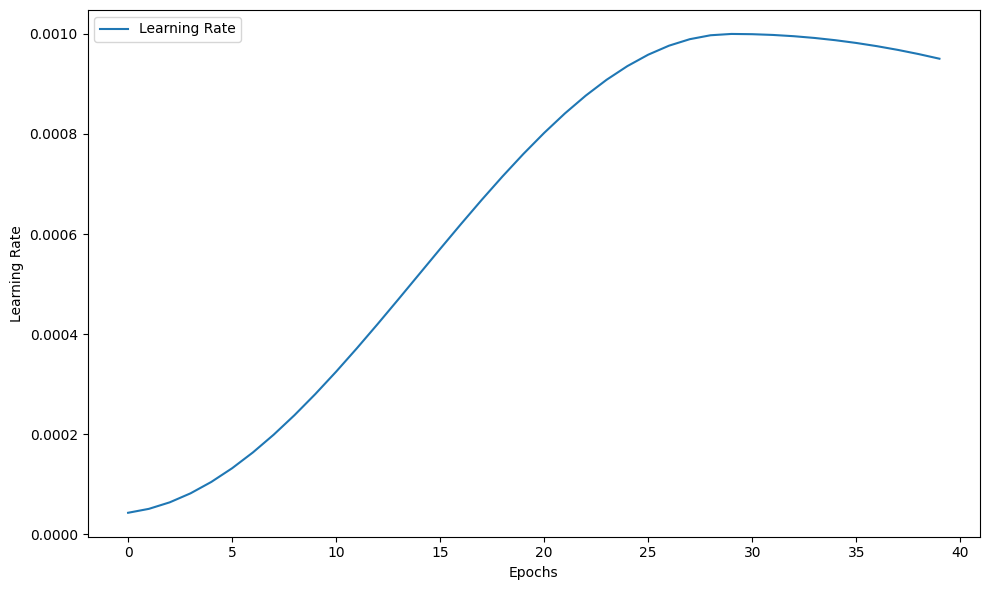

In [12]:
n_dim = X_train_transformed.shape[1]

cfg = AEConfig(
    in_dim=n_dim,
    bn_dim=3,
    hidden_dims=[64, 32, 16],
    )

results.append(
    run_ae_experiment(
      cfg,
      model_fn=make_tied_autoencoder,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      device=device)
)

Generated model_name: ae-128-64-32-16-3
Model parameters: 24653



Epoch 1/100:   1%|           | 1/100 [00:13<22:38, 13.72s/epoch, train_loss=0.8561, val_loss=0.6263]

Epoch 2/100:   2%|▏          | 2/100 [00:27<22:50, 13.98s/epoch, train_loss=0.4884, val_loss=0.4121]

Epoch 3/100:   3%|▎          | 3/100 [00:41<22:30, 13.92s/epoch, train_loss=0.3766, val_loss=0.3516]

Epoch 4/100:   4%|▍          | 4/100 [00:55<22:15, 13.91s/epoch, train_loss=0.3312, val_loss=0.3109]

Epoch 5/100:   5%|▌          | 5/100 [01:09<22:04, 13.94s/epoch, train_loss=0.2942, val_loss=0.2787]

Epoch 6/100:   6%|▋          | 6/100 [01:23<21:45, 13.88s/epoch, train_loss=0.2662, val_loss=0.2537]

Epoch 7/100:   7%|▊          | 7/100 [01:37<21:28, 13.86s/epoch, train_loss=0.2429, val_loss=0.2330]

Epoch 8/100:   8%|▉          | 8/100 [01:50<21:06, 13.77s/epoch, train_loss=0.2236, val_loss=0.2154]

Epoch 9/100:   9%|▉          | 9/100 [02:04<20:59, 13.84s/epoch, train_loss=0.2083, val_loss=0.2017]

Epoch 10/100:  10%|▉        | 10/100 [02:18<20:35, 13.73s/epoch, train_loss=0.1964, val_loss=0.1925]

Epoch 11/100:  11%|▉        | 11/100 [02:32<20:31, 13.84s/epoch, train_loss=0.1871, val_loss=0.1832]

Epoch 12/100:  12%|█        | 12/100 [02:45<20:09, 13.75s/epoch, train_loss=0.1799, val_loss=0.1764]

Epoch 13/100:  13%|█▏       | 13/100 [02:59<20:01, 13.82s/epoch, train_loss=0.1740, val_loss=0.1716]

Epoch 14/100:  14%|█▎       | 14/100 [03:13<19:47, 13.81s/epoch, train_loss=0.1690, val_loss=0.1677]

Epoch 15/100:  15%|█▎       | 15/100 [03:27<19:37, 13.85s/epoch, train_loss=0.1646, val_loss=0.1635]

Epoch 16/100:  16%|█▍       | 16/100 [03:41<19:22, 13.84s/epoch, train_loss=0.1613, val_loss=0.1598]

Epoch 17/100:  17%|█▌       | 17/100 [03:55<19:12, 13.89s/epoch, train_loss=0.1578, val_loss=0.1563]

Epoch 18/100:  18%|█▌       | 18/100 [04:09<19:01, 13.92s/epoch, train_loss=0.1548, val_loss=0.1527]

Epoch 19/100:  19%|█▋       | 19/100 [04:23<18:43, 13.87s/epoch, train_loss=0.1519, val_loss=0.1488]

Epoch 20/100:  20%|█▊       | 20/100 [04:37<18:33, 13.91s/epoch, train_loss=0.1490, val_loss=0.1477]

Epoch 21/100:  21%|█▉       | 21/100 [04:50<18:12, 13.83s/epoch, train_loss=0.1464, val_loss=0.1440]

Epoch 22/100:  22%|█▉       | 22/100 [05:05<18:08, 13.96s/epoch, train_loss=0.1448, val_loss=0.1451]

Epoch 23/100:  23%|██       | 23/100 [05:18<17:50, 13.90s/epoch, train_loss=0.1424, val_loss=0.1423]

Epoch 24/100:  24%|██▏      | 24/100 [05:33<17:43, 13.99s/epoch, train_loss=0.1412, val_loss=0.1405]

Epoch 25/100:  25%|██▎      | 25/100 [05:46<17:24, 13.93s/epoch, train_loss=0.1388, val_loss=0.1397]

Epoch 26/100:  26%|██▎      | 26/100 [06:00<17:09, 13.91s/epoch, train_loss=0.1376, val_loss=0.1356]

Epoch 27/100:  27%|██▍      | 27/100 [06:14<16:58, 13.96s/epoch, train_loss=0.1352, val_loss=0.1360]

Epoch 28/100:  28%|██▌      | 28/100 [06:28<16:42, 13.92s/epoch, train_loss=0.1336, val_loss=0.1317]

Epoch 29/100:  29%|██▌      | 29/100 [06:42<16:26, 13.90s/epoch, train_loss=0.1329, val_loss=0.1312]

Epoch 30/100:  30%|██▋      | 30/100 [06:56<16:06, 13.81s/epoch, train_loss=0.1307, val_loss=0.1303]

Epoch 31/100:  31%|██▊      | 31/100 [07:10<15:57, 13.88s/epoch, train_loss=0.1288, val_loss=0.1286]

Epoch 32/100:  32%|██▉      | 32/100 [07:23<15:39, 13.81s/epoch, train_loss=0.1282, val_loss=0.1264]

Epoch 33/100:  33%|██▉      | 33/100 [07:37<15:32, 13.92s/epoch, train_loss=0.1257, val_loss=0.1271]

Epoch 34/100:  34%|███      | 34/100 [07:51<15:13, 13.85s/epoch, train_loss=0.1249, val_loss=0.1266]

Epoch 35/100:  35%|███▏     | 35/100 [08:05<15:05, 13.93s/epoch, train_loss=0.1247, val_loss=0.1251]

Epoch 36/100:  36%|███▏     | 36/100 [08:19<14:49, 13.90s/epoch, train_loss=0.1251, val_loss=0.1231]

Epoch 37/100:  37%|███▎     | 37/100 [08:33<14:32, 13.86s/epoch, train_loss=0.1223, val_loss=0.1200]

Epoch 38/100:  38%|███▍     | 38/100 [08:47<14:22, 13.91s/epoch, train_loss=0.1211, val_loss=0.1192]

Epoch 39/100:  39%|███▌     | 39/100 [09:01<14:09, 13.93s/epoch, train_loss=0.1199, val_loss=0.1180]

Epoch 40/100:  40%|███▌     | 40/100 [09:15<13:58, 13.97s/epoch, train_loss=0.1182, val_loss=0.1169]

Epoch 41/100:  41%|███▋     | 41/100 [09:29<13:41, 13.92s/epoch, train_loss=0.1172, val_loss=0.1172]

Epoch 42/100:  42%|███▊     | 42/100 [09:46<14:28, 14.98s/epoch, train_loss=0.1158, val_loss=0.1171]

Epoch 43/100:  43%|███▊     | 43/100 [10:00<14:01, 14.76s/epoch, train_loss=0.1164, val_loss=0.1141]

Epoch 44/100:  44%|███▉     | 44/100 [10:15<13:40, 14.65s/epoch, train_loss=0.1145, val_loss=0.1146]

Epoch 45/100:  45%|████     | 45/100 [10:29<13:13, 14.42s/epoch, train_loss=0.1137, val_loss=0.1134]

Epoch 46/100:  46%|████▏    | 46/100 [10:43<12:52, 14.30s/epoch, train_loss=0.1132, val_loss=0.1150]

Epoch 47/100:  47%|████▏    | 47/100 [10:57<12:32, 14.21s/epoch, train_loss=0.1127, val_loss=0.1111]

Epoch 48/100:  48%|████▎    | 48/100 [11:11<12:22, 14.28s/epoch, train_loss=0.1119, val_loss=0.1093]

Epoch 49/100:  49%|████▍    | 49/100 [11:25<12:07, 14.27s/epoch, train_loss=0.1101, val_loss=0.1120]

Epoch 50/100:  50%|████▌    | 50/100 [11:40<11:54, 14.29s/epoch, train_loss=0.1090, val_loss=0.1090]

Epoch 51/100:  51%|████▌    | 51/100 [11:54<11:39, 14.28s/epoch, train_loss=0.1085, val_loss=0.1081]

Epoch 52/100:  52%|████▋    | 52/100 [12:09<11:39, 14.57s/epoch, train_loss=0.1088, val_loss=0.1095]

Epoch 53/100:  52%|████▋    | 52/100 [12:24<11:26, 14.31s/epoch, train_loss=0.1094, val_loss=0.1101]



Early stopping at epoch 53/100: train_loss=0.1094, val_loss=0.1101


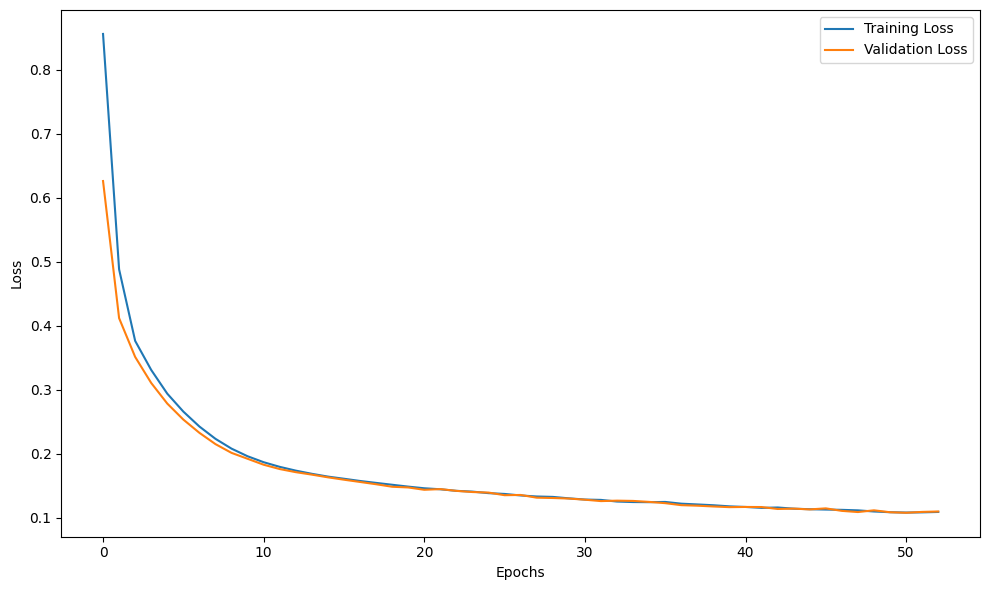

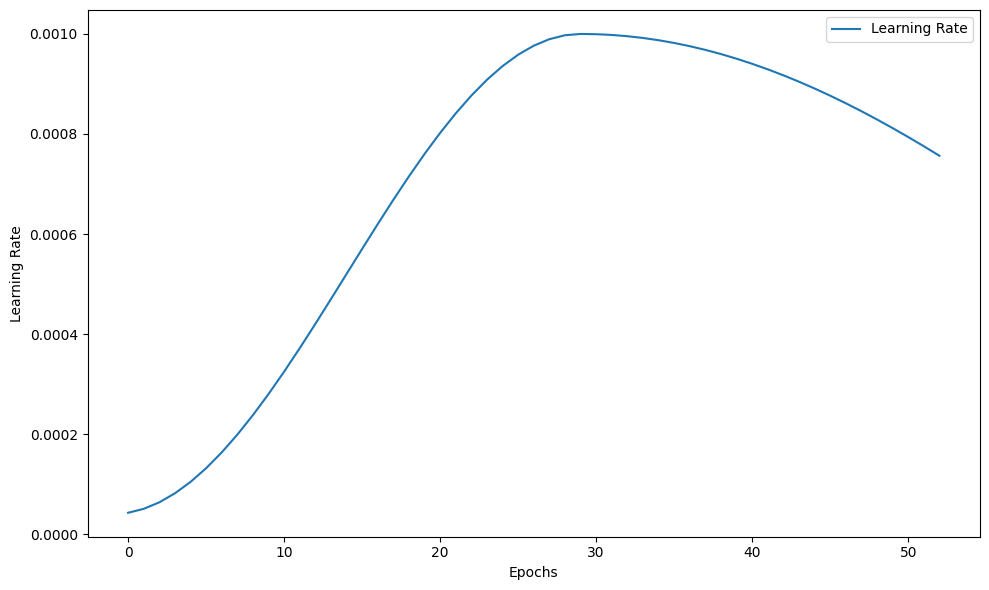

In [13]:
n_dim = X_train_transformed.shape[1]

cfg = AEConfig(
    in_dim=n_dim,
    bn_dim=3,
    hidden_dims=[128, 64, 32, 16],
    )

results.append(
    run_ae_experiment(
      cfg,
      model_fn=make_autoencoder,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      device=device)
)

Generated model_name: tae-128-64-32-16-3
Model parameters: 12573



Epoch 1/100:   1%|           | 1/100 [00:14<23:22, 14.17s/epoch, train_loss=0.8449, val_loss=0.6648]

Epoch 2/100:   2%|▏          | 2/100 [00:28<23:16, 14.25s/epoch, train_loss=0.5411, val_loss=0.4589]

Epoch 3/100:   3%|▎          | 3/100 [00:42<23:01, 14.25s/epoch, train_loss=0.4240, val_loss=0.3933]

Epoch 4/100:   4%|▍          | 4/100 [00:57<22:50, 14.28s/epoch, train_loss=0.3708, val_loss=0.3511]

Epoch 5/100:   5%|▌          | 5/100 [01:11<22:36, 14.28s/epoch, train_loss=0.3370, val_loss=0.3247]

Epoch 6/100:   6%|▋          | 6/100 [01:25<22:33, 14.40s/epoch, train_loss=0.3145, val_loss=0.3048]

Epoch 7/100:   7%|▊          | 7/100 [01:40<22:30, 14.52s/epoch, train_loss=0.2947, val_loss=0.2850]

Epoch 8/100:   8%|▉          | 8/100 [01:55<22:24, 14.61s/epoch, train_loss=0.2768, val_loss=0.2700]

Epoch 9/100:   9%|▉          | 9/100 [02:09<22:04, 14.55s/epoch, train_loss=0.2624, val_loss=0.2563]

Epoch 10/100:  10%|▉        | 10/100 [02:24<21:48, 14.54s/epoch, train_loss=0.2500, val_loss=0.2445]

Epoch 11/100:  11%|▉        | 11/100 [02:38<21:22, 14.42s/epoch, train_loss=0.2398, val_loss=0.2351]

Epoch 12/100:  12%|█        | 12/100 [02:53<21:09, 14.43s/epoch, train_loss=0.2312, val_loss=0.2277]

Epoch 13/100:  13%|█▏       | 13/100 [03:07<20:45, 14.32s/epoch, train_loss=0.2236, val_loss=0.2203]

Epoch 14/100:  14%|█▎       | 14/100 [03:21<20:32, 14.33s/epoch, train_loss=0.2170, val_loss=0.2138]

Epoch 15/100:  15%|█▎       | 15/100 [03:35<20:16, 14.31s/epoch, train_loss=0.2108, val_loss=0.2084]

Epoch 16/100:  16%|█▍       | 16/100 [03:50<20:01, 14.30s/epoch, train_loss=0.2055, val_loss=0.2031]

Epoch 17/100:  17%|█▌       | 17/100 [04:04<19:46, 14.30s/epoch, train_loss=0.2012, val_loss=0.1994]

Epoch 18/100:  18%|█▌       | 18/100 [04:18<19:30, 14.27s/epoch, train_loss=0.1970, val_loss=0.1958]

Epoch 19/100:  19%|█▋       | 19/100 [04:32<19:13, 14.24s/epoch, train_loss=0.1932, val_loss=0.1913]

Epoch 20/100:  20%|█▊       | 20/100 [04:46<18:53, 14.17s/epoch, train_loss=0.1899, val_loss=0.1885]

Epoch 21/100:  21%|█▉       | 21/100 [05:00<18:39, 14.18s/epoch, train_loss=0.1862, val_loss=0.1858]

Epoch 22/100:  22%|█▉       | 22/100 [05:14<18:18, 14.08s/epoch, train_loss=0.1835, val_loss=0.1839]

Epoch 23/100:  23%|██       | 23/100 [05:29<18:10, 14.16s/epoch, train_loss=0.1815, val_loss=0.1818]

Epoch 24/100:  24%|██▏      | 24/100 [05:43<17:52, 14.11s/epoch, train_loss=0.1787, val_loss=0.1797]

Epoch 25/100:  25%|██▎      | 25/100 [05:57<17:44, 14.19s/epoch, train_loss=0.1760, val_loss=0.1757]

Epoch 26/100:  26%|██▎      | 26/100 [06:11<17:28, 14.17s/epoch, train_loss=0.1737, val_loss=0.1711]

Epoch 27/100:  27%|██▍      | 27/100 [06:25<17:18, 14.22s/epoch, train_loss=0.1720, val_loss=0.1743]

Epoch 28/100:  28%|██▌      | 28/100 [06:40<17:11, 14.32s/epoch, train_loss=0.1721, val_loss=0.1700]

Epoch 29/100:  29%|██▌      | 29/100 [06:55<17:03, 14.42s/epoch, train_loss=0.1683, val_loss=0.1682]

Epoch 30/100:  30%|██▋      | 30/100 [07:09<16:56, 14.52s/epoch, train_loss=0.1678, val_loss=0.1719]

Epoch 31/100:  31%|██▊      | 31/100 [07:23<16:32, 14.38s/epoch, train_loss=0.1656, val_loss=0.1625]

Epoch 32/100:  32%|██▉      | 32/100 [07:38<16:18, 14.39s/epoch, train_loss=0.1633, val_loss=0.1618]

Epoch 33/100:  33%|██▉      | 33/100 [07:52<15:58, 14.31s/epoch, train_loss=0.1642, val_loss=0.1629]

Epoch 34/100:  34%|███      | 34/100 [08:06<15:47, 14.35s/epoch, train_loss=0.1641, val_loss=0.1591]

Epoch 35/100:  35%|███▏     | 35/100 [08:20<15:26, 14.26s/epoch, train_loss=0.1624, val_loss=0.1615]

Epoch 36/100:  36%|███▏     | 36/100 [08:35<15:15, 14.31s/epoch, train_loss=0.1606, val_loss=0.1596]

Epoch 37/100:  37%|███▎     | 37/100 [08:49<15:00, 14.29s/epoch, train_loss=0.1592, val_loss=0.1601]

Epoch 38/100:  38%|███▍     | 38/100 [09:03<14:46, 14.29s/epoch, train_loss=0.1595, val_loss=0.1580]

Epoch 39/100:  39%|███▌     | 39/100 [09:18<14:30, 14.27s/epoch, train_loss=0.1565, val_loss=0.1552]

Epoch 40/100:  40%|███▌     | 40/100 [09:32<14:16, 14.27s/epoch, train_loss=0.1552, val_loss=0.1547]

Epoch 41/100:  41%|███▋     | 41/100 [09:46<14:01, 14.26s/epoch, train_loss=0.1581, val_loss=0.1584]

Epoch 42/100:  42%|███▊     | 42/100 [10:00<13:43, 14.20s/epoch, train_loss=0.1591, val_loss=0.1545]

Epoch 43/100:  43%|███▊     | 43/100 [10:15<13:32, 14.26s/epoch, train_loss=0.1544, val_loss=0.1568]

Epoch 44/100:  44%|███▉     | 44/100 [10:29<13:14, 14.18s/epoch, train_loss=0.1530, val_loss=0.1515]

Epoch 45/100:  45%|████     | 45/100 [10:43<13:05, 14.28s/epoch, train_loss=0.1525, val_loss=0.1502]

Epoch 46/100:  46%|████▏    | 46/100 [10:57<12:48, 14.23s/epoch, train_loss=0.1512, val_loss=0.1513]

Epoch 47/100:  47%|████▏    | 47/100 [11:12<12:43, 14.41s/epoch, train_loss=0.1510, val_loss=0.1500]

Epoch 48/100:  47%|████▏    | 47/100 [11:27<12:54, 14.62s/epoch, train_loss=0.1508, val_loss=0.1500]



Early stopping at epoch 48/100: train_loss=0.1508, val_loss=0.1500


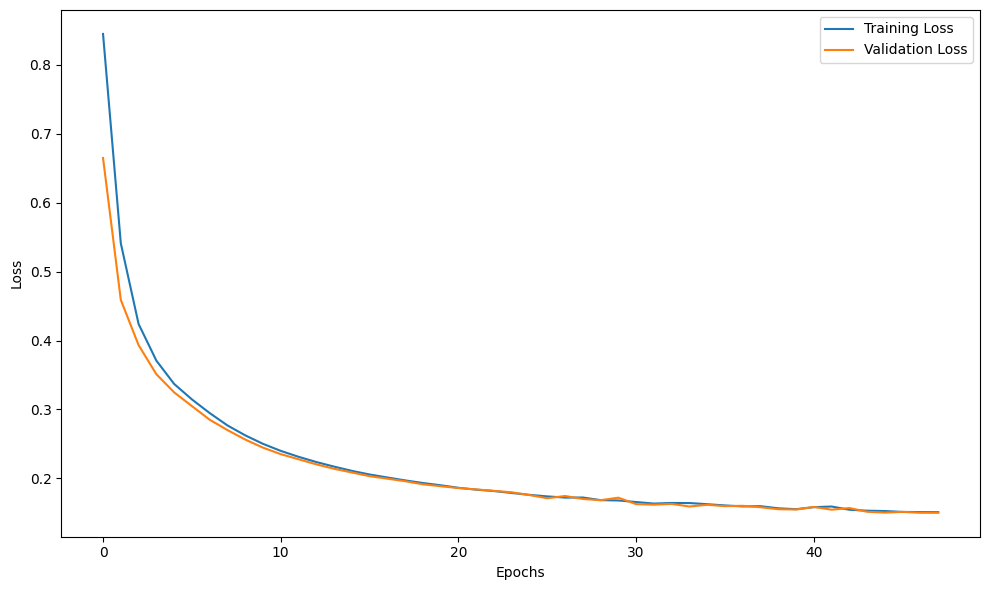

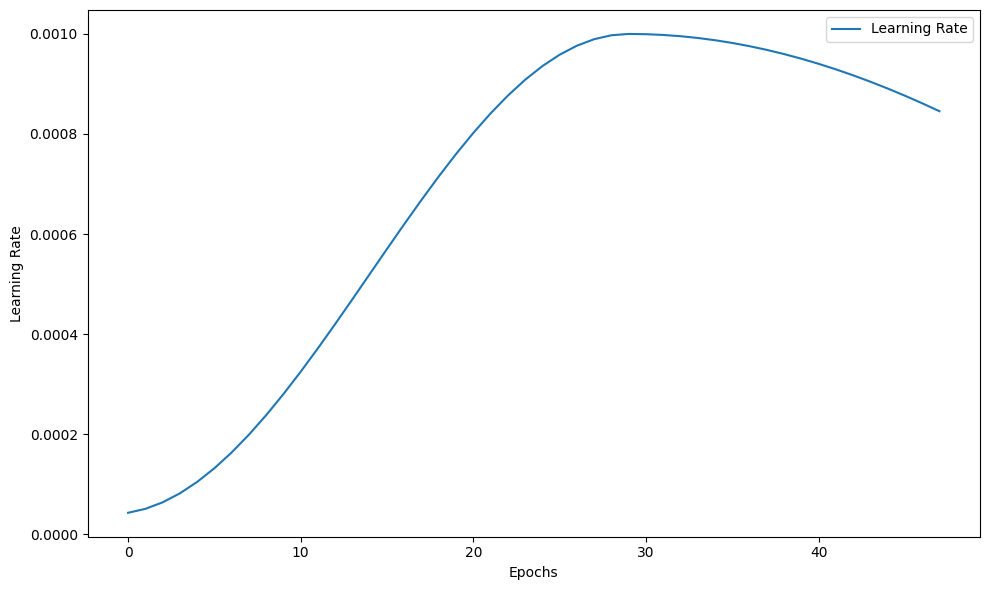

In [14]:
n_dim = X_train_transformed.shape[1]

cfg = AEConfig(
    in_dim=n_dim,
    bn_dim=3,
    hidden_dims=[128, 64, 32, 16],
    )

results.append(
    run_ae_experiment(
      cfg,
      model_fn=make_tied_autoencoder,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      device=device)
)

Generated model_name: tae-64-32-16-4
Model parameters: 3502



Epoch 1/100:   1%|           | 1/100 [00:10<17:12, 10.43s/epoch, train_loss=0.8515, val_loss=0.6973]

Epoch 2/100:   2%|▏          | 2/100 [00:21<17:46, 10.88s/epoch, train_loss=0.6108, val_loss=0.5168]

Epoch 3/100:   3%|▎          | 3/100 [00:32<17:49, 11.03s/epoch, train_loss=0.4221, val_loss=0.3469]

Epoch 4/100:   4%|▍          | 4/100 [00:43<17:40, 11.05s/epoch, train_loss=0.3269, val_loss=0.3103]

Epoch 5/100:   5%|▌          | 5/100 [00:54<17:23, 10.98s/epoch, train_loss=0.2987, val_loss=0.2841]

Epoch 6/100:   6%|▋          | 6/100 [01:05<16:48, 10.72s/epoch, train_loss=0.2699, val_loss=0.2531]

Epoch 7/100:   7%|▊          | 7/100 [01:16<16:47, 10.84s/epoch, train_loss=0.2381, val_loss=0.2220]

Epoch 8/100:   8%|▉          | 8/100 [01:27<16:45, 10.93s/epoch, train_loss=0.2100, val_loss=0.1962]

Epoch 9/100:   9%|▉          | 9/100 [01:38<16:40, 10.99s/epoch, train_loss=0.1858, val_loss=0.1756]

Epoch 10/100:  10%|▉        | 10/100 [01:49<16:38, 11.09s/epoch, train_loss=0.1693, val_loss=0.1629]

Epoch 11/100:  11%|▉        | 11/100 [01:59<15:59, 10.78s/epoch, train_loss=0.1581, val_loss=0.1533]

Epoch 12/100:  12%|█        | 12/100 [02:10<15:56, 10.87s/epoch, train_loss=0.1493, val_loss=0.1454]

Epoch 13/100:  13%|█▏       | 13/100 [02:21<15:52, 10.95s/epoch, train_loss=0.1418, val_loss=0.1385]

Epoch 14/100:  14%|█▎       | 14/100 [02:33<15:48, 11.02s/epoch, train_loss=0.1354, val_loss=0.1323]

Epoch 15/100:  15%|█▎       | 15/100 [02:44<15:37, 11.03s/epoch, train_loss=0.1298, val_loss=0.1272]

Epoch 16/100:  16%|█▍       | 16/100 [02:53<14:52, 10.62s/epoch, train_loss=0.1247, val_loss=0.1218]

Epoch 17/100:  17%|█▌       | 17/100 [03:05<14:59, 10.84s/epoch, train_loss=0.1205, val_loss=0.1180]

Epoch 18/100:  18%|█▌       | 18/100 [03:16<14:50, 10.86s/epoch, train_loss=0.1168, val_loss=0.1145]

Epoch 19/100:  19%|█▋       | 19/100 [03:27<14:48, 10.97s/epoch, train_loss=0.1128, val_loss=0.1108]

Epoch 20/100:  20%|█▊       | 20/100 [03:38<14:32, 10.91s/epoch, train_loss=0.1093, val_loss=0.1078]

Epoch 21/100:  21%|█▉       | 21/100 [03:48<14:06, 10.71s/epoch, train_loss=0.1059, val_loss=0.1048]

Epoch 22/100:  22%|█▉       | 22/100 [03:59<14:02, 10.80s/epoch, train_loss=0.1030, val_loss=0.1012]

Epoch 23/100:  23%|██       | 23/100 [04:10<13:59, 10.90s/epoch, train_loss=0.0997, val_loss=0.0980]

Epoch 24/100:  24%|██▏      | 24/100 [04:21<13:52, 10.95s/epoch, train_loss=0.0971, val_loss=0.0955]

Epoch 25/100:  25%|██▎      | 25/100 [04:32<13:36, 10.89s/epoch, train_loss=0.0950, val_loss=0.0939]

Epoch 26/100:  26%|██▎      | 26/100 [04:42<13:10, 10.68s/epoch, train_loss=0.0930, val_loss=0.0918]

Epoch 27/100:  27%|██▍      | 27/100 [04:53<13:01, 10.71s/epoch, train_loss=0.0919, val_loss=0.0920]

Epoch 28/100:  28%|██▌      | 28/100 [05:04<13:03, 10.89s/epoch, train_loss=0.0906, val_loss=0.0888]

Epoch 29/100:  29%|██▌      | 29/100 [05:15<12:54, 10.91s/epoch, train_loss=0.0891, val_loss=0.0884]

Epoch 30/100:  30%|██▋      | 30/100 [05:26<12:37, 10.83s/epoch, train_loss=0.0873, val_loss=0.0860]

Epoch 31/100:  31%|██▊      | 31/100 [05:36<12:13, 10.63s/epoch, train_loss=0.0864, val_loss=0.0863]

Epoch 32/100:  32%|██▉      | 32/100 [05:47<12:15, 10.82s/epoch, train_loss=0.0855, val_loss=0.0850]

Epoch 33/100:  33%|██▉      | 33/100 [05:58<12:09, 10.89s/epoch, train_loss=0.0843, val_loss=0.0841]

Epoch 34/100:  34%|███      | 34/100 [06:09<12:05, 10.99s/epoch, train_loss=0.0840, val_loss=0.0830]

Epoch 35/100:  35%|███▏     | 35/100 [06:20<11:50, 10.93s/epoch, train_loss=0.0827, val_loss=0.0832]

Epoch 36/100:  36%|███▏     | 36/100 [06:31<11:32, 10.82s/epoch, train_loss=0.0829, val_loss=0.0865]

Epoch 37/100:  37%|███▎     | 37/100 [06:42<11:27, 10.91s/epoch, train_loss=0.0827, val_loss=0.0829]

Epoch 38/100:  38%|███▍     | 38/100 [06:53<11:17, 10.93s/epoch, train_loss=0.0817, val_loss=0.0817]

Epoch 39/100:  39%|███▌     | 39/100 [07:04<11:14, 11.05s/epoch, train_loss=0.0812, val_loss=0.0803]

Epoch 40/100:  39%|███▌     | 39/100 [07:14<11:20, 11.15s/epoch, train_loss=0.0800, val_loss=0.0791]



Early stopping at epoch 40/100: train_loss=0.0800, val_loss=0.0791


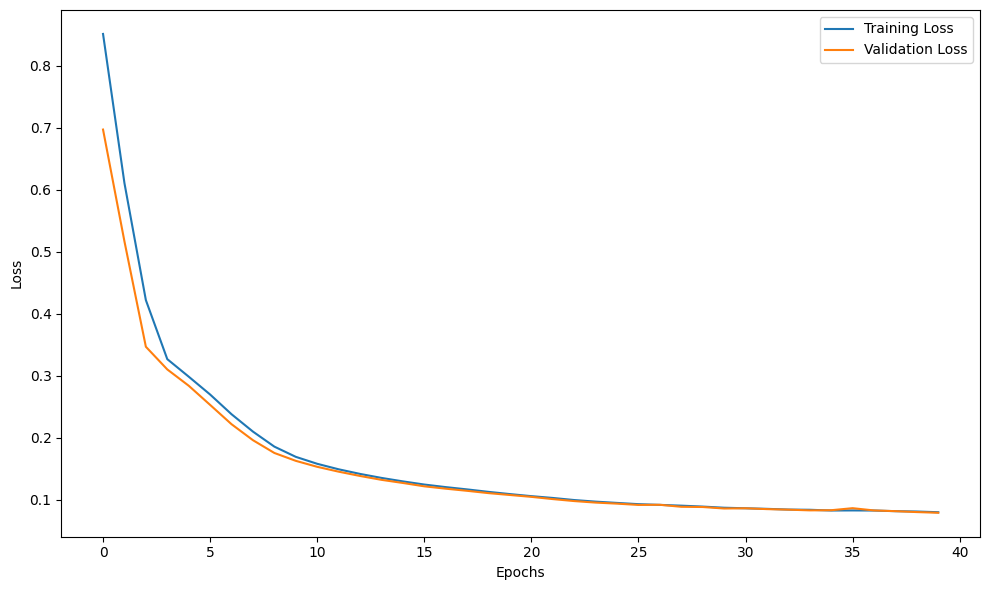

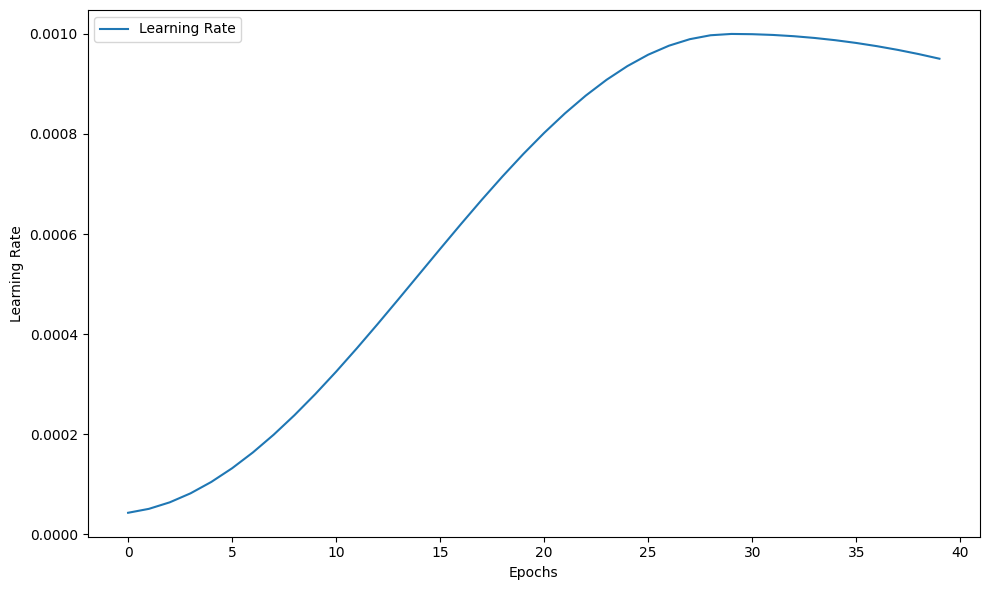

In [15]:
n_dim = X_train_transformed.shape[1]

cfg = AEConfig(
    in_dim=n_dim,
    bn_dim=4,
    hidden_dims=[64, 32, 16],
    )

results.append(
    run_ae_experiment(
      cfg,
      model_fn=make_tied_autoencoder,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      device=device)
)

Generated model_name: tae-128-64-32-16-4
Model parameters: 12590



Epoch 1/100:   1%|           | 1/100 [00:14<24:28, 14.84s/epoch, train_loss=0.8253, val_loss=0.6492]

Epoch 2/100:   2%|▏          | 2/100 [00:29<23:41, 14.51s/epoch, train_loss=0.5310, val_loss=0.4390]

Epoch 3/100:   3%|▎          | 3/100 [00:43<23:10, 14.34s/epoch, train_loss=0.3571, val_loss=0.3043]

Epoch 4/100:   4%|▍          | 4/100 [00:57<22:46, 14.23s/epoch, train_loss=0.2824, val_loss=0.2634]

Epoch 5/100:   5%|▌          | 5/100 [01:17<26:01, 16.44s/epoch, train_loss=0.2511, val_loss=0.2387]

Epoch 6/100:   6%|▋          | 6/100 [01:31<24:22, 15.56s/epoch, train_loss=0.2303, val_loss=0.2209]

Epoch 7/100:   7%|▊          | 7/100 [01:45<23:23, 15.09s/epoch, train_loss=0.2133, val_loss=0.2050]

Epoch 8/100:   8%|▉          | 8/100 [01:59<22:31, 14.68s/epoch, train_loss=0.1975, val_loss=0.1903]

Epoch 9/100:   9%|▉          | 9/100 [02:13<21:58, 14.49s/epoch, train_loss=0.1824, val_loss=0.1753]

Epoch 10/100:  10%|▉        | 10/100 [02:27<21:20, 14.23s/epoch, train_loss=0.1695, val_loss=0.1642]

Epoch 11/100:  11%|▉        | 11/100 [02:41<21:01, 14.18s/epoch, train_loss=0.1598, val_loss=0.1555]

Epoch 12/100:  12%|█        | 12/100 [02:56<21:07, 14.41s/epoch, train_loss=0.1521, val_loss=0.1483]

Epoch 13/100:  13%|█▏       | 13/100 [03:10<20:48, 14.35s/epoch, train_loss=0.1452, val_loss=0.1415]

Epoch 14/100:  14%|█▎       | 14/100 [03:24<20:35, 14.37s/epoch, train_loss=0.1387, val_loss=0.1358]

Epoch 15/100:  15%|█▎       | 15/100 [03:38<20:16, 14.31s/epoch, train_loss=0.1328, val_loss=0.1296]

Epoch 16/100:  16%|█▍       | 16/100 [03:53<20:04, 14.34s/epoch, train_loss=0.1274, val_loss=0.1242]

Epoch 17/100:  17%|█▌       | 17/100 [04:07<19:40, 14.22s/epoch, train_loss=0.1225, val_loss=0.1214]

Epoch 18/100:  18%|█▌       | 18/100 [04:22<19:38, 14.38s/epoch, train_loss=0.1184, val_loss=0.1184]

Epoch 19/100:  19%|█▋       | 19/100 [04:35<19:12, 14.23s/epoch, train_loss=0.1148, val_loss=0.1142]

Epoch 20/100:  20%|█▊       | 20/100 [04:50<18:59, 14.25s/epoch, train_loss=0.1119, val_loss=0.1101]

Epoch 21/100:  21%|█▉       | 21/100 [05:04<18:38, 14.15s/epoch, train_loss=0.1092, val_loss=0.1075]

Epoch 22/100:  22%|█▉       | 22/100 [05:18<18:26, 14.18s/epoch, train_loss=0.1074, val_loss=0.1064]

Epoch 23/100:  23%|██       | 23/100 [05:32<18:07, 14.13s/epoch, train_loss=0.1054, val_loss=0.1042]

Epoch 24/100:  24%|██▏      | 24/100 [05:46<18:00, 14.22s/epoch, train_loss=0.1039, val_loss=0.1019]

Epoch 25/100:  25%|██▎      | 25/100 [06:01<17:47, 14.23s/epoch, train_loss=0.1017, val_loss=0.1003]

Epoch 26/100:  26%|██▎      | 26/100 [06:15<17:33, 14.23s/epoch, train_loss=0.1006, val_loss=0.1000]

Epoch 27/100:  27%|██▍      | 27/100 [06:29<17:15, 14.19s/epoch, train_loss=0.0993, val_loss=0.0990]

Epoch 28/100:  28%|██▌      | 28/100 [06:43<16:56, 14.12s/epoch, train_loss=0.0980, val_loss=0.0965]

Epoch 29/100:  29%|██▌      | 29/100 [06:57<16:51, 14.25s/epoch, train_loss=0.0965, val_loss=0.0937]

Epoch 30/100:  30%|██▋      | 30/100 [07:12<16:35, 14.23s/epoch, train_loss=0.0954, val_loss=0.0940]

Epoch 31/100:  31%|██▊      | 31/100 [07:26<16:26, 14.30s/epoch, train_loss=0.0947, val_loss=0.0925]

Epoch 32/100:  32%|██▉      | 32/100 [07:40<16:05, 14.20s/epoch, train_loss=0.0935, val_loss=0.0921]

Epoch 33/100:  33%|██▉      | 33/100 [07:55<15:59, 14.32s/epoch, train_loss=0.0930, val_loss=0.0935]

Epoch 34/100:  34%|███      | 34/100 [08:09<15:43, 14.30s/epoch, train_loss=0.0926, val_loss=0.0915]

Epoch 35/100:  35%|███▏     | 35/100 [08:23<15:27, 14.27s/epoch, train_loss=0.0914, val_loss=0.0892]

Epoch 36/100:  36%|███▏     | 36/100 [08:37<15:10, 14.22s/epoch, train_loss=0.0902, val_loss=0.0895]

Epoch 37/100:  37%|███▎     | 37/100 [08:52<15:00, 14.30s/epoch, train_loss=0.0893, val_loss=0.0900]

Epoch 38/100:  38%|███▍     | 38/100 [09:06<14:50, 14.36s/epoch, train_loss=0.0887, val_loss=0.0874]

Epoch 39/100:  39%|███▌     | 39/100 [09:21<14:38, 14.39s/epoch, train_loss=0.0881, val_loss=0.0876]

Epoch 40/100:  40%|███▌     | 40/100 [09:35<14:31, 14.52s/epoch, train_loss=0.0882, val_loss=0.0885]

Epoch 41/100:  41%|███▋     | 41/100 [09:49<14:07, 14.36s/epoch, train_loss=0.0878, val_loss=0.0858]

Epoch 42/100:  42%|███▊     | 42/100 [10:04<13:50, 14.31s/epoch, train_loss=0.0870, val_loss=0.0861]

Epoch 43/100:  43%|███▊     | 43/100 [10:18<13:29, 14.20s/epoch, train_loss=0.0861, val_loss=0.0855]

Epoch 44/100:  44%|███▉     | 44/100 [10:32<13:15, 14.20s/epoch, train_loss=0.0855, val_loss=0.0858]

Epoch 45/100:  44%|███▉     | 44/100 [10:46<13:42, 14.69s/epoch, train_loss=0.0854, val_loss=0.0874]



Early stopping at epoch 45/100: train_loss=0.0854, val_loss=0.0874


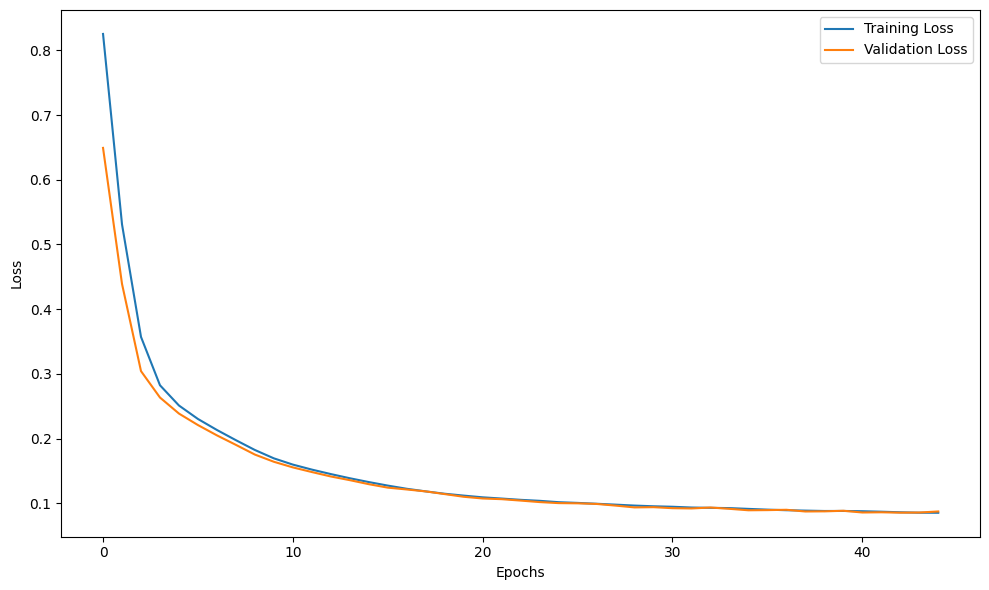

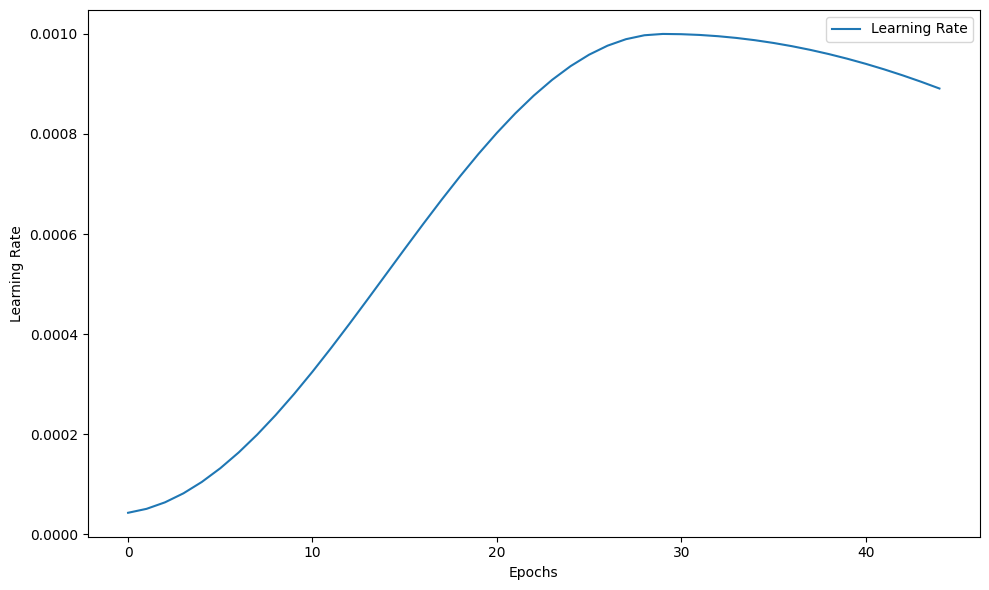

In [16]:
n_dim = X_train_transformed.shape[1]

cfg = AEConfig(
    in_dim=n_dim,
    bn_dim=4,
    hidden_dims=[128, 64, 32, 16],
    )

results.append(
    run_ae_experiment(
      cfg,
      model_fn=make_tied_autoencoder,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      device=device)
)

Generated model_name: ae-128-64-32-16-4
Model parameters: 24686



Epoch 1/100:   1%|           | 1/100 [00:14<23:14, 14.08s/epoch, train_loss=0.8752, val_loss=0.6920]

Epoch 2/100:   2%|▏          | 2/100 [00:28<22:59, 14.08s/epoch, train_loss=0.5818, val_loss=0.4683]

Epoch 3/100:   3%|▎          | 3/100 [00:42<22:41, 14.04s/epoch, train_loss=0.4252, val_loss=0.3824]

Epoch 4/100:   4%|▍          | 4/100 [00:56<22:23, 13.99s/epoch, train_loss=0.3132, val_loss=0.2752]

Epoch 5/100:   5%|▌          | 5/100 [01:10<22:12, 14.03s/epoch, train_loss=0.2528, val_loss=0.2335]

Epoch 6/100:   6%|▋          | 6/100 [01:24<22:01, 14.06s/epoch, train_loss=0.2165, val_loss=0.2032]

Epoch 7/100:   7%|▊          | 7/100 [01:38<21:43, 14.02s/epoch, train_loss=0.1937, val_loss=0.1855]

Epoch 8/100:   8%|▉          | 8/100 [01:52<21:31, 14.03s/epoch, train_loss=0.1780, val_loss=0.1718]

Epoch 9/100:   9%|▉          | 9/100 [02:06<21:17, 14.03s/epoch, train_loss=0.1650, val_loss=0.1593]

Epoch 10/100:  10%|▉        | 10/100 [02:20<20:59, 14.00s/epoch, train_loss=0.1539, val_loss=0.1485]

Epoch 11/100:  11%|▉        | 11/100 [02:34<20:46, 14.01s/epoch, train_loss=0.1451, val_loss=0.1423]

Epoch 12/100:  12%|█        | 12/100 [02:48<20:28, 13.96s/epoch, train_loss=0.1379, val_loss=0.1356]

Epoch 13/100:  13%|█▏       | 13/100 [03:02<20:24, 14.07s/epoch, train_loss=0.1320, val_loss=0.1295]

Epoch 14/100:  14%|█▎       | 14/100 [03:16<20:00, 13.96s/epoch, train_loss=0.1274, val_loss=0.1259]

Epoch 15/100:  15%|█▎       | 15/100 [03:30<19:54, 14.05s/epoch, train_loss=0.1235, val_loss=0.1211]

Epoch 16/100:  16%|█▍       | 16/100 [03:44<19:38, 14.03s/epoch, train_loss=0.1205, val_loss=0.1194]

Epoch 17/100:  17%|█▌       | 17/100 [03:58<19:30, 14.10s/epoch, train_loss=0.1177, val_loss=0.1156]

Epoch 18/100:  18%|█▌       | 18/100 [04:12<19:16, 14.11s/epoch, train_loss=0.1146, val_loss=0.1136]

Epoch 19/100:  19%|█▋       | 19/100 [04:27<19:08, 14.18s/epoch, train_loss=0.1121, val_loss=0.1137]

Epoch 20/100:  20%|█▊       | 20/100 [04:41<18:57, 14.22s/epoch, train_loss=0.1101, val_loss=0.1109]

Epoch 21/100:  21%|█▉       | 21/100 [04:55<18:42, 14.20s/epoch, train_loss=0.1079, val_loss=0.1108]

Epoch 22/100:  22%|█▉       | 22/100 [05:10<18:35, 14.30s/epoch, train_loss=0.1063, val_loss=0.1057]

Epoch 23/100:  23%|██       | 23/100 [05:24<18:13, 14.20s/epoch, train_loss=0.1045, val_loss=0.1054]

Epoch 24/100:  24%|██▏      | 24/100 [05:38<18:05, 14.28s/epoch, train_loss=0.1031, val_loss=0.1017]

Epoch 25/100:  25%|██▎      | 25/100 [05:52<17:43, 14.18s/epoch, train_loss=0.1005, val_loss=0.0984]

Epoch 26/100:  26%|██▎      | 26/100 [06:06<17:30, 14.20s/epoch, train_loss=0.0988, val_loss=0.1009]

Epoch 27/100:  27%|██▍      | 27/100 [06:20<17:07, 14.08s/epoch, train_loss=0.0986, val_loss=0.0970]

Epoch 28/100:  28%|██▌      | 28/100 [06:34<16:56, 14.12s/epoch, train_loss=0.0972, val_loss=0.0959]

Epoch 29/100:  29%|██▌      | 29/100 [06:48<16:35, 14.03s/epoch, train_loss=0.0966, val_loss=0.0960]

Epoch 30/100:  30%|██▋      | 30/100 [07:02<16:26, 14.09s/epoch, train_loss=0.0939, val_loss=0.0910]

Epoch 31/100:  31%|██▊      | 31/100 [07:16<16:10, 14.07s/epoch, train_loss=0.0925, val_loss=0.0941]

Epoch 32/100:  32%|██▉      | 32/100 [07:30<15:54, 14.03s/epoch, train_loss=0.0901, val_loss=0.0873]

Epoch 33/100:  33%|██▉      | 33/100 [07:44<15:38, 14.01s/epoch, train_loss=0.0891, val_loss=0.0873]

Epoch 34/100:  34%|███      | 34/100 [07:58<15:20, 13.95s/epoch, train_loss=0.0877, val_loss=0.0861]

Epoch 35/100:  35%|███▏     | 35/100 [08:12<15:13, 14.05s/epoch, train_loss=0.0882, val_loss=0.0905]

Epoch 36/100:  36%|███▏     | 36/100 [08:26<14:54, 13.97s/epoch, train_loss=0.0866, val_loss=0.0848]

Epoch 37/100:  37%|███▎     | 37/100 [08:40<14:42, 14.01s/epoch, train_loss=0.0863, val_loss=0.0864]

Epoch 38/100:  38%|███▍     | 38/100 [08:54<14:23, 13.93s/epoch, train_loss=0.0859, val_loss=0.0881]

Epoch 39/100:  39%|███▌     | 39/100 [09:08<14:16, 14.04s/epoch, train_loss=0.0855, val_loss=0.0910]

Epoch 40/100:  40%|███▌     | 40/100 [09:22<13:59, 13.99s/epoch, train_loss=0.0866, val_loss=0.0857]

Epoch 41/100:  41%|███▋     | 41/100 [09:36<13:50, 14.08s/epoch, train_loss=0.0833, val_loss=0.0817]

Epoch 42/100:  42%|███▊     | 42/100 [09:50<13:34, 14.05s/epoch, train_loss=0.0844, val_loss=0.0859]

Epoch 43/100:  43%|███▊     | 43/100 [10:05<13:23, 14.10s/epoch, train_loss=0.0844, val_loss=0.0842]

Epoch 44/100:  44%|███▉     | 44/100 [10:19<13:07, 14.05s/epoch, train_loss=0.0870, val_loss=0.0848]

Epoch 45/100:  45%|████     | 45/100 [10:32<12:49, 13.98s/epoch, train_loss=0.0838, val_loss=0.0825]

Epoch 46/100:  46%|████▏    | 46/100 [10:47<12:37, 14.03s/epoch, train_loss=0.0817, val_loss=0.0791]

Epoch 47/100:  47%|████▏    | 47/100 [11:00<12:20, 13.97s/epoch, train_loss=0.0788, val_loss=0.0775]

Epoch 48/100:  48%|████▎    | 48/100 [11:15<12:12, 14.09s/epoch, train_loss=0.0774, val_loss=0.0780]

Epoch 49/100:  49%|████▍    | 49/100 [11:29<11:55, 14.03s/epoch, train_loss=0.0779, val_loss=0.0797]

Epoch 50/100:  50%|████▌    | 50/100 [11:43<11:46, 14.12s/epoch, train_loss=0.0804, val_loss=0.0802]

Epoch 51/100:  51%|████▌    | 51/100 [11:57<11:30, 14.09s/epoch, train_loss=0.0776, val_loss=0.0756]

Epoch 52/100:  52%|████▋    | 52/100 [12:12<11:24, 14.26s/epoch, train_loss=0.0769, val_loss=0.0774]

Epoch 53/100:  53%|████▊    | 53/100 [12:26<11:14, 14.36s/epoch, train_loss=0.0779, val_loss=0.0781]

Epoch 54/100:  54%|████▊    | 54/100 [12:41<11:01, 14.38s/epoch, train_loss=0.0769, val_loss=0.0745]

Epoch 55/100:  55%|████▉    | 55/100 [12:55<10:42, 14.29s/epoch, train_loss=0.0762, val_loss=0.0804]

Epoch 56/100:  56%|█████    | 56/100 [13:09<10:24, 14.20s/epoch, train_loss=0.0779, val_loss=0.0748]

Epoch 57/100:  57%|█████▏   | 57/100 [13:23<10:12, 14.24s/epoch, train_loss=0.0734, val_loss=0.0727]

Epoch 58/100:  58%|█████▏   | 58/100 [13:37<09:54, 14.17s/epoch, train_loss=0.0723, val_loss=0.0739]

Epoch 59/100:  59%|█████▎   | 59/100 [13:51<09:40, 14.17s/epoch, train_loss=0.0746, val_loss=0.0762]

Epoch 60/100:  60%|█████▍   | 60/100 [14:05<09:23, 14.09s/epoch, train_loss=0.0771, val_loss=0.0748]

Epoch 61/100:  61%|█████▍   | 61/100 [14:20<09:13, 14.19s/epoch, train_loss=0.0729, val_loss=0.0721]

Epoch 62/100:  62%|█████▌   | 62/100 [14:34<08:58, 14.16s/epoch, train_loss=0.0720, val_loss=0.0717]

Epoch 63/100:  63%|█████▋   | 63/100 [14:48<08:46, 14.23s/epoch, train_loss=0.0726, val_loss=0.0731]

Epoch 64/100:  64%|█████▊   | 64/100 [15:02<08:31, 14.20s/epoch, train_loss=0.0721, val_loss=0.0732]

Epoch 65/100:  65%|█████▊   | 65/100 [15:16<08:17, 14.22s/epoch, train_loss=0.0720, val_loss=0.0720]

Epoch 66/100:  66%|█████▉   | 66/100 [15:31<08:03, 14.21s/epoch, train_loss=0.0717, val_loss=0.0720]

Epoch 67/100:  67%|██████   | 67/100 [15:45<07:47, 14.17s/epoch, train_loss=0.0717, val_loss=0.0711]

Epoch 68/100:  68%|██████   | 68/100 [15:59<07:34, 14.22s/epoch, train_loss=0.0713, val_loss=0.0704]

Epoch 69/100:  69%|██████▏  | 69/100 [16:13<07:20, 14.20s/epoch, train_loss=0.0704, val_loss=0.0711]

Epoch 70/100:  70%|██████▎  | 70/100 [16:28<07:08, 14.27s/epoch, train_loss=0.0695, val_loss=0.0703]

Epoch 71/100:  71%|██████▍  | 71/100 [16:42<06:51, 14.21s/epoch, train_loss=0.0708, val_loss=0.0747]

Epoch 72/100:  72%|██████▍  | 72/100 [16:56<06:39, 14.25s/epoch, train_loss=0.0712, val_loss=0.0699]

Epoch 73/100:  73%|██████▌  | 73/100 [17:10<06:25, 14.28s/epoch, train_loss=0.0695, val_loss=0.0704]

Epoch 74/100:  74%|██████▋  | 74/100 [17:25<06:15, 14.45s/epoch, train_loss=0.0693, val_loss=0.0691]

Epoch 75/100:  75%|██████▊  | 75/100 [17:40<06:04, 14.59s/epoch, train_loss=0.0688, val_loss=0.0692]

Epoch 76/100:  76%|██████▊  | 76/100 [17:55<05:51, 14.64s/epoch, train_loss=0.0681, val_loss=0.0678]

Epoch 77/100:  77%|██████▉  | 77/100 [18:09<05:35, 14.59s/epoch, train_loss=0.0666, val_loss=0.0665]

Epoch 78/100:  78%|███████  | 78/100 [18:24<05:18, 14.47s/epoch, train_loss=0.0665, val_loss=0.0672]

Epoch 79/100:  79%|███████  | 79/100 [18:38<05:04, 14.48s/epoch, train_loss=0.0668, val_loss=0.0670]

Epoch 80/100:  80%|███████▏ | 80/100 [18:52<04:47, 14.37s/epoch, train_loss=0.0666, val_loss=0.0671]

Epoch 81/100:  80%|███████▏ | 80/100 [19:07<04:46, 14.34s/epoch, train_loss=0.0663, val_loss=0.0666]



Early stopping at epoch 81/100: train_loss=0.0663, val_loss=0.0666


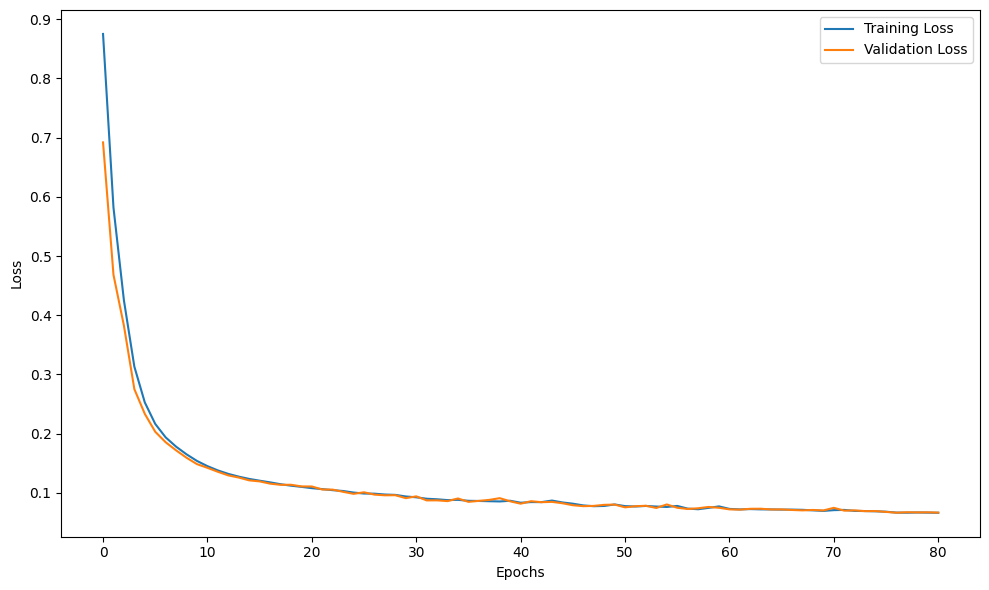

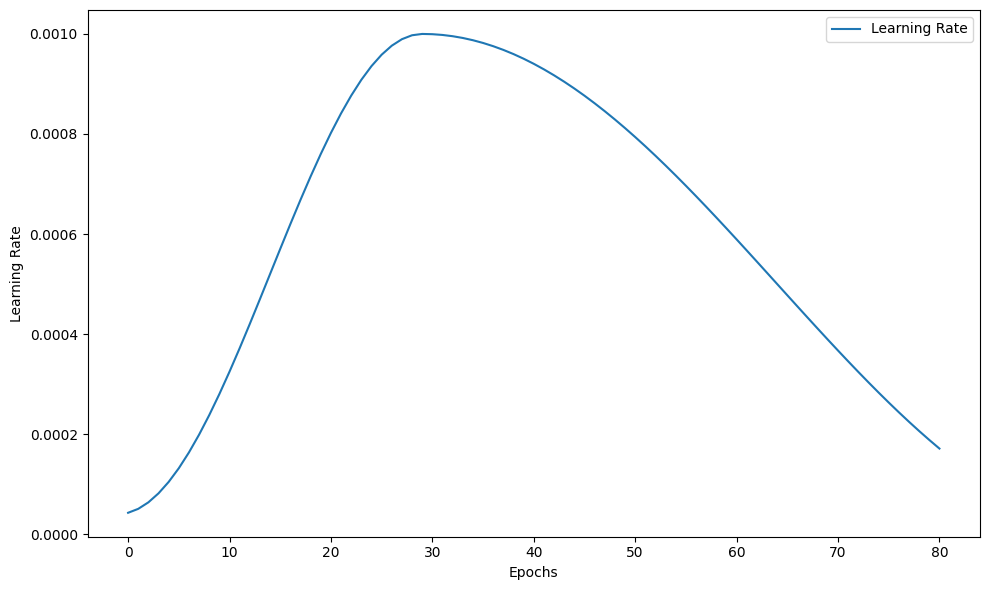

In [17]:
n_dim = X_train_transformed.shape[1]

cfg = AEConfig(
    in_dim=n_dim,
    bn_dim=4,
    hidden_dims=[128, 64, 32, 16],
    patience=30
    )

results.append(
    run_ae_experiment(
      cfg,
      model_fn=make_autoencoder,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      device=device)
)

## Exporting

In [18]:
results_df = pd.DataFrame(results)
results_df.sort_values("val_loss")

,model,hidden_dims,bottleneck_dim,train_loss,val_loss,params
6,ae-128-64-32-16-4,"[128, 64, 32, 16]",4,0.066339,0.066650,24686
4,tae-64-32-16-4,"[64, 32, 16]",4,0.080002,0.079104,3502
5,tae-128-64-32-16-4,"[128, 64, 32, 16]",4,0.085370,0.087401,12590
2,ae-128-64-32-16-3,"[128, 64, 32, 16]",3,0.109408,0.110134,24653
1,tae-64-32-16-3,"[64, 32, 16]",3,0.137213,0.137120,3485
0,ae-64-32-16-3,"[64, 32, 16]",3,0.144258,0.143439,6733
3,tae-128-64-32-16-3,"[128, 64, 32, 16]",3,0.150849,0.149969,12573


In [19]:
BEST_MODEL = "ae-128-64-32-16-4" + ".pt"

X = pd.read_csv(training_data_fp)

X_np = X.to_numpy()
X_tensor = torch.FloatTensor(X_np)
X_tensor = X_tensor.to(device)

model = load_model(AutoEncoder, BEST_MODEL, device)
model.eval()

with torch.no_grad():
  z = model.encode(X_tensor)

z = z.cpu().detach().numpy()

z.shape

(1176724, 4)

In [20]:
fp = "phase_1/encoder_transformed_data.csv"
path = os.path.join(data_path, fp)

z = pd.DataFrame(z)
z.to_csv(path, index=False)